# Datascience for Ad Tech 2018
### Predicting view time of video ads
*Team JDA : BOIVIN Jolyanne, BOUCHER Axel, GRIGNARD Jeremy, KARTHIGESU Dinojan*

# Introduction

The goal of this competition is to predict the time a user will watch a video ad.

Each line of the dataset is identified by its auction_id and depicts one impression for a given context: user, publisher, advertiser.

The evaluation metric is the RMSE (see section Evaluation) but this metric is not necessarily the best proxy for the performance of the model in a production context

## Columns description

- auction_id - a unique id for identifying each line
- timestamp - the timestamp (in seconds) of the ad impression
- creative_duration - the total duration of the video that has been played
- campaign_id - the advertising campaign id
- advertiser_id - the advertiser id
- placement_id - the id of zone in the web page where the video was played-
- placement_language - the language of this zone
- website_id - the corresponding website id
- referer_deep_three - the url of the page where the video was played, truncated at its 3rd level
- ua_country - the country of the user who saw the video
- ua_os - the user Operating System
- ua_browser - the user internet browser
- ua_browser_version - the user browser version
- ua_device - the user device
- user_average_seconds_played - the average duration the user watched video ads in the past. Can be null if the user never watched any ad.
- seconds_played - the observed time the video has been watched. This is the quantity you want to predict, consequently you will only find it in the training set.

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('data/training.csv')
test = pd.read_csv('data/test.csv')

In [3]:
print("Train Set shape : " + str(train.shape))
train.head()

Train Set shape : (3000000, 17)


,auction_id,timestamp,creative_duration,creative_id,campaign_id,advertiser_id,placement_id,placement_language,website_id,referer_deep_three,ua_country,ua_os,ua_browser,ua_browser_version,ua_device,user_average_seconds_played,seconds_played
0,0008b046-b675-4f51-8ad6-fe06e5d81f8e,1517334694,25,198280,210671,7109.0,47216,fr,31838,de/golf/publish,ch,Windows,Microsoft Edge,16.0,PersonalComputer,NaN,9
1,00095bac-8fec-48c8-a17b-8f3878359e1d,1517270483,29,195285,210074,2270.0,77249,fr,46416,com/vinepair/articles,uk,Windows,Chrome,64.0,PersonalComputer,NaN,8
2,000c4c0c-0789-4e50-8ba6-a4be920ab482,1517339899,60,201430,214063,2643.0,25817,fr,20824,co.uk/hastingsobserver/news,uk,iOS,Facebook App,NaN,Tablet,NaN,1
3,000db509-3350-4cd9-b60a-d506fbd31f29,1517346542,29,198262,215400,2244.0,86526,fr,39091,com/slate/news-and-politics,us,Windows,Chrome,63.0,PersonalComputer,18.166666,1
4,001300de-8eda-480f-bec8-4b46ef6117f2,1517310926,29,174590,184750,3617.0,85350,fr,14796,co.uk/independent/arts-entertainment,uk,Windows,Firefox,58.0,PersonalComputer,NaN,0


In [4]:
print("Test Set shape : " + str(test.shape))
test.head()

Test Set shape : (1000000, 16)


,auction_id,timestamp,creative_duration,creative_id,campaign_id,advertiser_id,placement_id,placement_language,website_id,referer_deep_three,ua_country,ua_os,ua_browser,ua_browser_version,ua_device,user_average_seconds_played
0,0001a52c-77b7-49e5-9e6f-0f13d0c4c065,1517403290,29,201701,214397,5500.0,66536,fr,39541,fr/leparisien/societe,fr,Android,Chrome Mobile,64.0,Tablet,22.0
1,000273fa-3ca0-4292-a57e-84edec163147,1517417795,21,199890,212176,1413.0,30466,fr,23288,com/elpais/internacional,us,iOS,Safari mobile,10.0,Phone,NaN
2,000307cf-c967-451c-a698-3a9f9f7afe4e,1517426142,29,202354,215274,9307.0,59626,fr,37824,com/indystar/story,us,Windows,Chrome,63.0,PersonalComputer,15.0
3,00034736-1879-427f-9d62-07142dac540f,1517409216,69,201862,214627,1328.0,67283,fr,41761,com/hkej/www2,hk,iOS,Facebook App,NaN,Phone,NaN
4,000560aa-3a06-46a0-9502-0c093b3bb327,1517435607,14,198848,211331,2168.0,46479,fr,31511,it/oggi/people,it,Android,Chrome Mobile,64.0,Phone,5.0


### Sets Infos

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 17 columns):
auction_id                     object
timestamp                      int64
creative_duration              int64
creative_id                    int64
campaign_id                    int64
advertiser_id                  float64
placement_id                   int64
placement_language             object
website_id                     int64
referer_deep_three             object
ua_country                     object
ua_os                          object
ua_browser                     object
ua_browser_version             float64
ua_device                      object
user_average_seconds_played    float64
seconds_played                 int64
dtypes: float64(3), int64(7), object(7)
memory usage: 389.1+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 16 columns):
auction_id                     1000000 non-null object
timestamp                      1000000 non-null int64
creative_duration              1000000 non-null int64
creative_id                    1000000 non-null int64
campaign_id                    1000000 non-null int64
advertiser_id                  988902 non-null float64
placement_id                   1000000 non-null int64
placement_language             999814 non-null object
website_id                     1000000 non-null int64
referer_deep_three             980011 non-null object
ua_country                     999993 non-null object
ua_os                          1000000 non-null object
ua_browser                     1000000 non-null object
ua_browser_version             800478 non-null float64
ua_device                      999961 non-null object
user_average_seconds_played    361575 non-null float64
dtypes: float64(3)

### Visualization

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


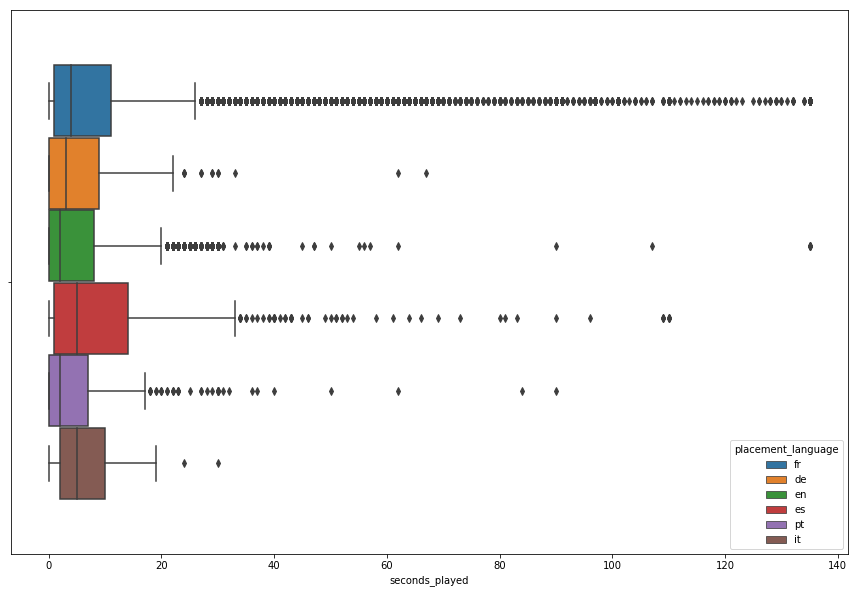

In [103]:
plt.figure(figsize=(15,10))
sns.boxplot(x=train.seconds_played, y=[""]*len(train), hue=train.placement_language);

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


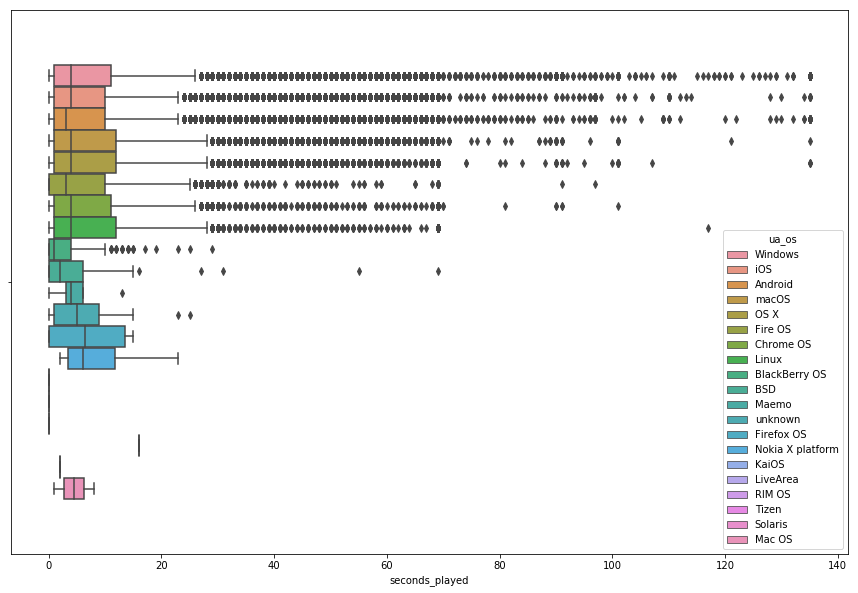

In [97]:
plt.figure(figsize=(15,10))
sns.boxplot(x=train.seconds_played, y=[""]*len(train), hue=train.ua_os);

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


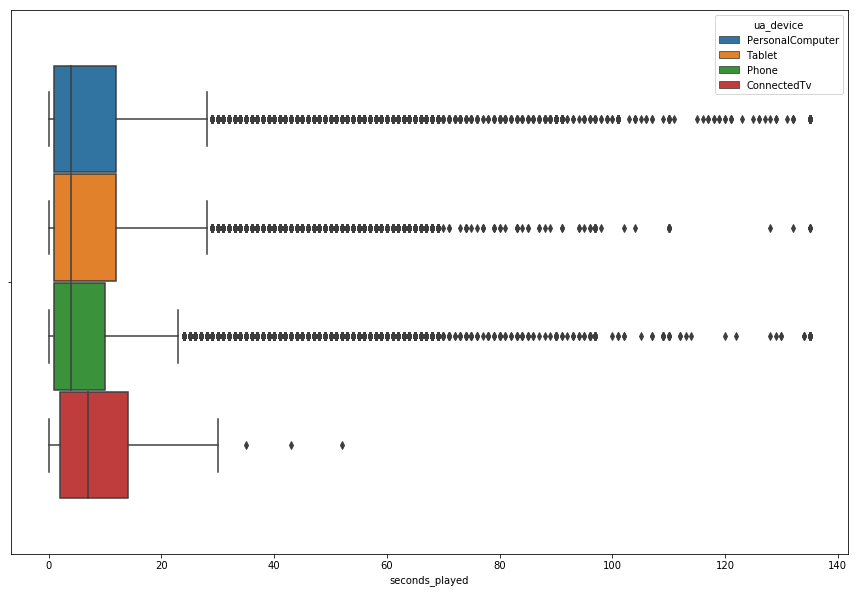

In [114]:
plt.figure(figsize=(15,10))
sns.boxplot(x=train.seconds_played, y=[""]*len(train), hue=train.ua_device);

### Target Distribution

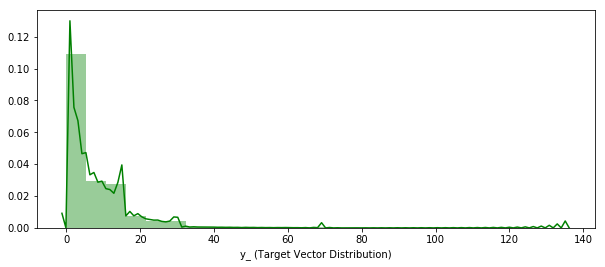

In [111]:
#Organize Data
SR_y = pd.Series(y_, name="y_ (Target Vector Distribution)")

#Plot Data
fig, ax = plt.subplots(figsize=(10, 4))
sns.distplot(SR_y, bins=25, color="g", ax=ax)
plt.show()

### Log Trick useful ?

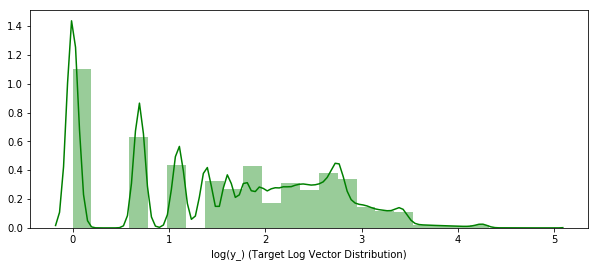

In [112]:
#Organize Data
SR_y = pd.Series(np.log(y_ + 1), name="log(y_) (Target Log Vector Distribution)")

#Plot Data
fig, ax = plt.subplots(figsize=(10, 4))
sns.distplot(SR_y, bins=25, color="g", ax=ax)
plt.show()

### Correlation Heatmap

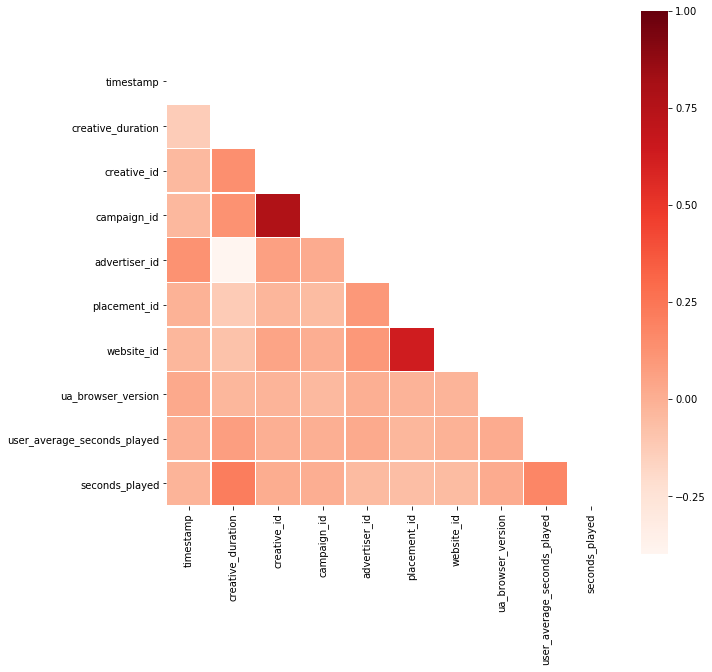

In [119]:
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap="Reds",
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": 1}, ax=ax);

###  Null Values in Sets

In [38]:
for col in train.columns:
    if pd.isnull(train[col]).values.any():
        print('NaNs in', col, train[col].dtypes)
        d = dict(Counter(pd.isnull(train[col])))
        nans = ( d[True] / (d[True] + d[False]) ) * 100
        print('Proportion of NaNs: %f %%' % ( nans))
        print('-----------------------------')

NaNs in advertiser_id float64
Proportion of NaNs: 1.381467 %
-----------------------------
NaNs in placement_language object
Proportion of NaNs: 0.006300 %
-----------------------------
NaNs in referer_deep_three object
Proportion of NaNs: 1.223233 %
-----------------------------
NaNs in ua_country object
Proportion of NaNs: 0.000467 %
-----------------------------
NaNs in ua_browser_version float64
Proportion of NaNs: 20.001333 %
-----------------------------
NaNs in ua_device object
Proportion of NaNs: 0.006600 %
-----------------------------
NaNs in user_average_seconds_played float64
Proportion of NaNs: 63.343167 %
-----------------------------


In [39]:
for col in test.columns:
    if pd.isnull(test[col]).values.any():
        print('NaNs in', col, test[col].dtypes)
        d = dict(Counter(pd.isnull(test[col])))
        nans = ( d[True] / (d[True] + d[False]) ) * 100
        print('Proportion of NaNs: %f %%' % ( nans))
        print('-----------------------------')

NaNs in advertiser_id float64
Proportion of NaNs: 1.109800 %
-----------------------------
NaNs in placement_language object
Proportion of NaNs: 0.018600 %
-----------------------------
NaNs in referer_deep_three object
Proportion of NaNs: 1.998900 %
-----------------------------
NaNs in ua_country object
Proportion of NaNs: 0.000700 %
-----------------------------
NaNs in ua_browser_version float64
Proportion of NaNs: 19.952200 %
-----------------------------
NaNs in ua_device object
Proportion of NaNs: 0.003900 %
-----------------------------
NaNs in user_average_seconds_played float64
Proportion of NaNs: 63.842500 %
-----------------------------


In [40]:
print('Number of entries: ',len(train))
print('Number of entries when all NaNs are dropped: ' ,len(train.dropna()))

Number of entries:  3000000
Number of entries when all NaNs are dropped:  926493


#### Placement language

In [63]:
Counter(train.placement_language.values)

Counter({'fr': 2984649,
         'de': 1363,
         'en': 10623,
         'es': 2677,
         'pt': 466,
         'it': 33,
         nan: 189})

In [62]:
print(train[train['placement_language'].isnull()]['ua_country'].unique())
print(test[test['placement_language'].isnull()]['ua_country'].unique())

['fr']
['fr']


Mode of placement_language is 'fr' and missing values correspond to a 'fr' in ua_country so : 

In [66]:
train.replace({'placement_language': {np.nan : 'fr'}}, inplace = True)
test.replace({'placement_language': {np.nan : 'fr'}}, inplace = True)

#### Ua Country

In [79]:
'nl' in train.ua_country.unique()

True

In [81]:
train[train['ua_country'].isnull()].head(1)

,auction_id,timestamp,creative_duration,creative_id,campaign_id,advertiser_id,placement_id,placement_language,website_id,referer_deep_three,ua_country,ua_os,ua_browser,ua_browser_version,ua_device,user_average_seconds_played,seconds_played
378173,8d9badeb-369b-4e66-acde-e12679283b01,1517328160,59,202571,215482,NaN,82443,fr,48756,nl/quotenet/Nieuws,NaN,Android,Chrome Mobile,63.0,Phone,NaN,4


Missing values in ua_country seems to correspond to a Netherlands Url when looking at referer_deep_three (in both train and test set) :

In [82]:
train.replace({'ua_country': {np.nan : 'nl'}}, inplace = True)
test.replace({'ua_country': {np.nan : 'nl'}}, inplace = True)

#### Ua Browser Version

In [107]:
train[train['ua_browser_version'].isnull()]['ua_browser'].unique()

array(['Facebook App', 'Safari mobile', 'Android webview',
       'Android HttpURLConnection', 'Twitter App', 'BlackBerry Browser',
       'PS4 Web browser', 'unknown', 'Android browser', 'CM Browser',
       'Firefox', 'Mozilla', 'Apple Mail', 'Iron mobile', 'Avant Browser',
       'Ubuntu web browser', 'Orange browser', 'Safari'], dtype=object)

In [116]:
len(train[train['ua_browser_version'].isnull()])

600040

Quasiment que des browsers smartphone, et bcp de NaNs

#### Ua Device

In [52]:
Counter(train.ua_device.values)

Counter({'PersonalComputer': 1022438,
         'Tablet': 302771,
         'Phone': 1674503,
         nan: 198,
         'ConnectedTv': 90})

In [104]:
print(train[train['ua_device'].isnull()]['ua_browser'].unique())
print(test[test['ua_device'].isnull()]['ua_browser'].unique())

['PS4 Web browser' 'unknown' 'Microsoft Edge' 'PS Vita browser']
['PS4 Web browser' 'unknown' 'Microsoft Edge' 'PS Vita browser']


Consoles ou Autres ?

In [117]:
train.replace({'ua_device': {np.nan : 'Console&Others'}}, inplace = True)
test.replace({'ua_device': {np.nan : 'Console&Others'}}, inplace = True)

#### Average seconds played

In [121]:
len(train[train['user_average_seconds_played'].isnull()])

1900295

Shitload of NaNs. La feature a l'air strong mais faut trouver quoi en faire. (fill 0 ou avg là-dessus est pas faisaible, la prédire reviens à prédire seconds_played)

## Test rapide Random Forest avec label encoding

In [125]:
from sklearn.preprocessing import LabelEncoder
from time import time

def label_encode_categorical(df):
    
    # Create new dataframe which will contain only numerical features
    df_encoded = pd.DataFrame()
    
    for col in df.columns:
        
        # Encode all categorical features with LabelEncoder
        if df[col].dtypes == np.dtype('object'):
            print('Encoding...')
            le = LabelEncoder()
            t0 = time()
            le.fit(np.unique(df[col].values))
            df_encoded[col] = df[col].map(lambda x: le.transform([x])[0])
            print('%s encoded (%f s)' %(col, time()-t0))
            
        # Keep the remaining numerical features as they are (to be treated afterwards)
        else:
            df_encoded[col] = df[col]
    return df_encoded

In [128]:
train = train.dropna()
len(train)

926617

In [130]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(train, test_size=0.3)
train.shape, validation.shape

((648631, 17), (277986, 17))

In [133]:
train.columns

Index(['auction_id', 'timestamp', 'creative_duration', 'creative_id',
       'campaign_id', 'advertiser_id', 'placement_id', 'placement_language',
       'website_id', 'referer_deep_three', 'ua_country', 'ua_os', 'ua_browser',
       'ua_browser_version', 'ua_device', 'user_average_seconds_played',
       'seconds_played'],
      dtype='object')

In [139]:
featuresToTakeForTraining = ['timestamp', 'creative_duration', 'creative_id',
       'campaign_id', 'advertiser_id', 'placement_id', 'placement_language',
       'website_id', 'ua_country', 'ua_os', 'ua_browser',
       'ua_browser_version', 'ua_device', 'user_average_seconds_played']

In [140]:
y_train = train['seconds_played']
y_validation = validation['seconds_played']

X_train = train[featuresToTakeForTraining]
X_validation = validation[featuresToTakeForTraining]

In [141]:
X_train = label_encode_categorical(X_train)
X_train.head()

Encoding...
placement_language encoded (52.276213 s)
Encoding...
ua_country encoded (81.598082 s)
Encoding...
ua_os encoded (55.862762 s)
Encoding...
ua_browser encoded (81.319882 s)
Encoding...
ua_device encoded (46.831333 s)


,timestamp,creative_duration,creative_id,campaign_id,advertiser_id,placement_id,placement_language,website_id,ua_country,ua_os,ua_browser,ua_browser_version,ua_device,user_average_seconds_played
1583268,1517281189,15,198116,210363,8120.0,72422,3,44250,60,10,48,9.0,3,20.000000
2759965,1517299440,24,201534,214182,2636.0,70822,3,29252,9,9,19,11.0,1,12.705882
1540151,1517329499,9,202597,215568,7906.0,71354,3,43714,59,0,8,63.0,2,2.000000
842,1517328976,29,201701,214397,5500.0,82405,3,19658,21,0,8,64.0,2,3.000000
2346328,1517352406,29,198114,210361,8120.0,40666,3,19190,60,9,7,63.0,1,35.642857


In [142]:
X_validation = label_encode_categorical(X_validation)
X_validation.head()

Encoding...
placement_language encoded (21.211096 s)
Encoding...
ua_country encoded (29.156749 s)
Encoding...
ua_os encoded (23.170513 s)
Encoding...
ua_browser encoded (30.031359 s)
Encoding...
ua_device encoded (20.707740 s)


,timestamp,creative_duration,creative_id,campaign_id,advertiser_id,placement_id,placement_language,website_id,ua_country,ua_os,ua_browser,ua_browser_version,ua_device,user_average_seconds_played
1149441,1517350291,15,200092,212567,2578.0,67605,3,41930,16,4,5,65.0,1,17.000000
891329,1517284577,30,201296,213746,6152.0,86765,3,51131,49,8,40,11.0,2,2.000000
398469,1517285026,29,198063,210347,3562.0,80209,3,39378,49,7,5,64.0,1,3.000000
758579,1517304297,29,202102,214988,6445.0,45760,3,19309,7,7,14,11.0,1,17.074074
2752607,1517299584,69,201861,214626,1328.0,68947,3,42580,44,7,5,64.0,1,9.000000


### Score function : RMSE

In [143]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### Models

In [155]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_validation)
y_pred_train = reg.predict(X_train)

score_train = rmse(y_pred_train, y_train.values)
score_test = rmse(y_pred, y_validation.values)

print("\t Score (trainning):", score_train, "\n")
print("\t Score (testing):", score_test, "\n")

	 Score (trainning): 8.918307255063546 

	 Score (testing): 8.887276640478767 



In [144]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators = 200, max_depth = 7, min_samples_split = 2)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_validation)
y_pred_train = rfr.predict(X_train)

score_train = rmse(y_pred_train, y_train.values)
score_test = rmse(y_pred, y_validation.values)

print("\t Score (trainning):", score_train, "\n")
print("\t Score (testing):", score_test, "\n")

	 Score (trainning): 8.613030057126513 

	 Score (testing): 8.624273453122742 



In [150]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(n_estimators = 200)
ada.fit(X_train, y_train)

y_proba_test = ada.predict(X_validation)
y_proba_train = ada.predict(X_train)

score_train = rmse(y_proba_train, y_train.values)
score_test = rmse(y_proba_test, y_validation.values)

print("\t Score (trainning):", score_train, "\n")
print("\t Score (testing):", score_test, "\n")

	 Score (trainning): 11.676225023436286 

	 Score (testing): 11.707427413641025 



In [153]:
import xgboost as xgb

def rmse_xg(yhat, y):
    y = y.get_label()
    return "rmse", rmse(yhat, y)

params = {"objective": "reg:linear", # fonction perte => regression linéaire car on prédit des ventes
          "eta": 0.3,
          "max_depth": 6, #on peut augmenter la profondeur mais augmente les chances d'overfit
          "subsample": 0.6,
          "colsample_bytree": 0.7
          }

dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_validation, y_validation)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

model = xgb.train(params, dtrain, 250, evals = watchlist, early_stopping_rounds = 10, feval = rmse_xg, verbose_eval = 5)

[0]	eval-rmse:10.2681	train-rmse:10.3269	eval-rmse:10.2681	train-rmse:10.3269
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[5]	eval-rmse:8.6518	train-rmse:8.6663	eval-rmse:8.6518	train-rmse:8.6663
[10]	eval-rmse:8.57323	train-rmse:8.55943	eval-rmse:8.57323	train-rmse:8.55943
[15]	eval-rmse:8.55318	train-rmse:8.53053	eval-rmse:8.55318	train-rmse:8.53053
[20]	eval-rmse:8.54375	train-rmse:8.5096	eval-rmse:8.54375	train-rmse:8.5096
[25]	eval-rmse:8.53416	train-rmse:8.49015	eval-rmse:8.53416	train-rmse:8.49015
[30]	eval-rmse:8.52849	train-rmse:8.47615	eval-rmse:8.52849	train-rmse:8.47615
[35]	eval-rmse:8.52327	train-rmse:8.46412	eval-rmse:8.52327	train-rmse:8.46412
[40]	eval-rmse:8.52026	train-rmse:8.4534	eval-rmse:8.52026	train-rmse:8.4534
[45]	eval-rmse:8.51837	train-rmse:8.44313	eval-rmse:8.51837	train-rmse:8.44313
[50]	eval-rmse:8.52011	train-rmse:8.43179	eval-rmse:8.52011	train-rmse:8.43

In [154]:
train_probs = model.predict(xgb.DMatrix(X_train))
test_probs = model.predict(xgb.DMatrix(X_validation))

print('Error on training set ', rmse(train_probs, y_train.values))
print('Error on testing set ', rmse(test_probs, y_validation.values))

Error on training set  8.196052573076656
Error on testing set  8.572302716370922


https://www.analyticsvidhya.com/blog/2016/07/practical-guide-data-preprocessing-python-scikit-learn/